# Title of Your Group Project

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [35]:
from simulate import simulate
from utils import save_simulated_data
# Run simulation and save to csv
# agent_type = 'model_based'
# agent_type = 'model_free'
# agent_type = 'random'

task_df_r , agent_r= simulate(agent_type='random')
task_df_mf , agent_mf= simulate(agent_type='model_free')
task_df_mb , agent_mb= simulate(agent_type='model_based')
# save_simulated_data(task_df_r, agent_type='random')
# save_simulated_data(task_df_mf, agent_type='model_free')
# save_simulated_data(task_df_mb, agent_type='model_based')

### random
common transitions percentage: 69.0 %
rewarded trails percentage: 53.0 %
### model_free
common transitions percentage: 72.5 %
rewarded trails percentage: 42.0 %
### model_based
common transitions percentage: 70.0 %
rewarded trails percentage: 48.0 %


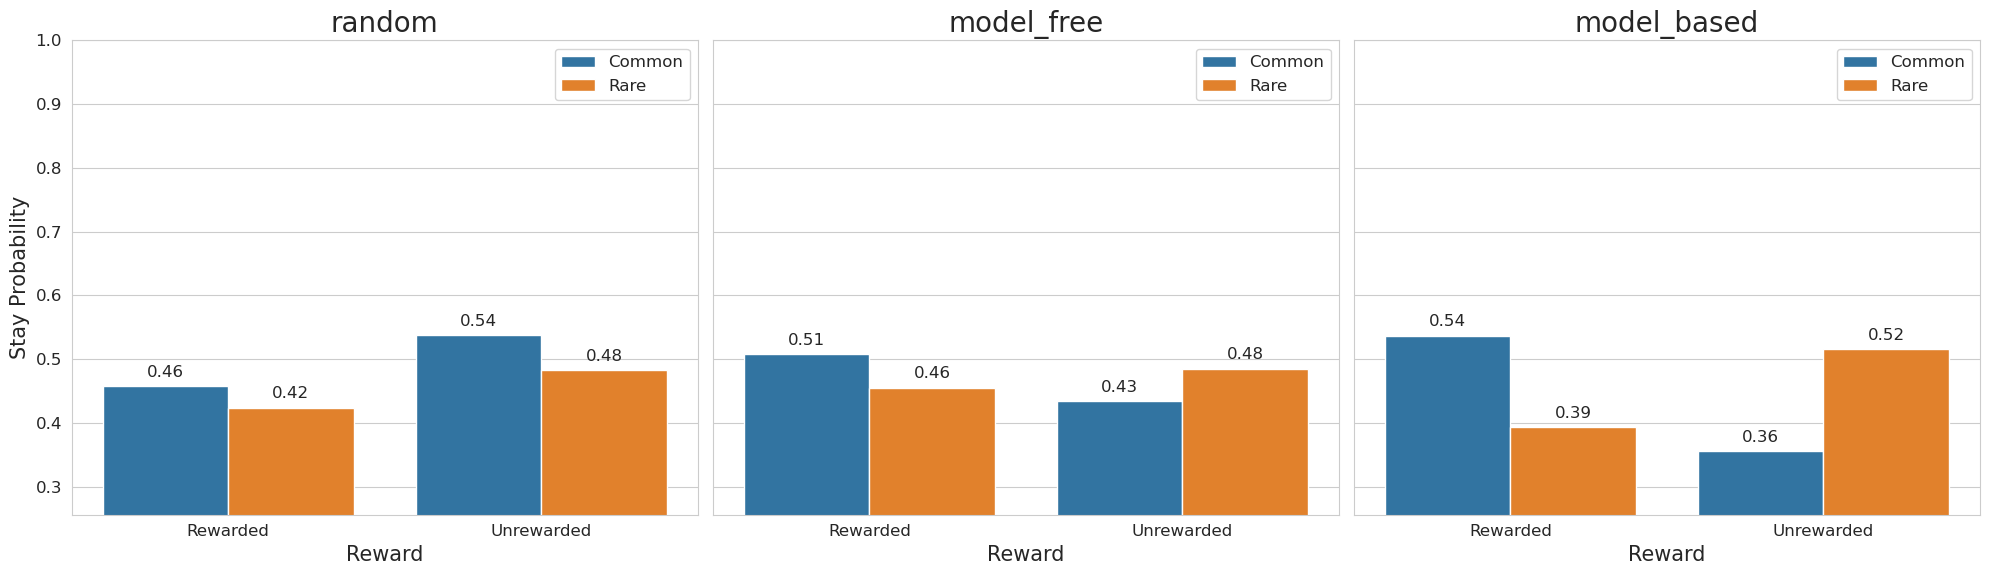

In [36]:
from utils import calculate_stay_probability, plot_stay_probability, plot_stay_probabilities, print_simple_statistics

# print q table and transition matrix
# print("q_table model free:\n", agent_mf.q_table)
# print("q_table model based:\n", agent_mb.q_table)
# if hasattr(agent_mb, 'transition_model'):
#     print("transition_matrix model based:\n", agent_mb.transition_model[0])

# print some statistics 
print_simple_statistics(task_df_r, title='random')
print_simple_statistics(task_df_mf, title='model_free')
print_simple_statistics(task_df_mb, title='model_based')

# calculate and plot stay probability
stay_probability_r, _ = calculate_stay_probability(task_df_r)
stay_probability_mf, _ = calculate_stay_probability(task_df_mf)
stay_probability_mb, _ = calculate_stay_probability(task_df_mb)
plot_stay_probabilities(dfs=[stay_probability_r,
                            stay_probability_mf,
                            stay_probability_mb],
                        labels=['random',
                                'model_free',
                                'model_based'])

# display(task_df_extended[['stepOneChoice', 'repeated_stepOneAction', 'repeated_stepOneAction_next','reward', 'common_transition']])


### experiment_data_mj.csv
common transitions percentage: 70.5 %
rewarded trails percentage: 56.99999999999999 %


,Rewarded,Common,Stay Probability,Condition
0,False,False,0.538,unrewarded_rare
1,False,True,0.517,unrewarded_common
2,True,False,0.312,rewarded_rare
3,True,True,0.889,rewarded_common


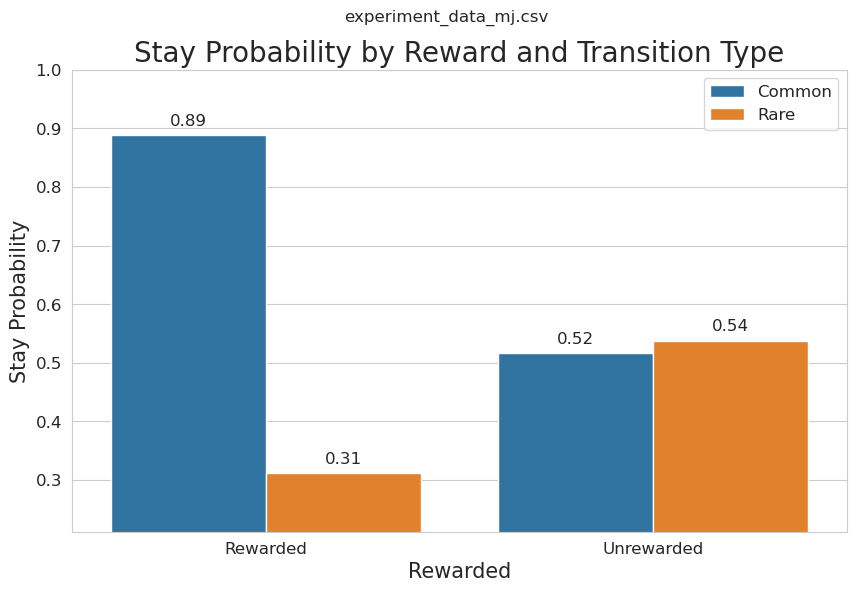

In [37]:
import pandas as pd
import os
from utils import preprocess_human_data, calculate_stay_probability, plot_stay_probability, print_simple_statistics

# load and inspect human data
particepant_data_file = "experiment_data_mj.csv"
file_name = os.path.join("data", "participants", particepant_data_file)
human_data = pd.read_csv(file_name)

# preprocess human data
human_data = preprocess_human_data(human_data)

# print some statistics
print_simple_statistics(human_data, title=particepant_data_file)

# calculate and plot stay probability
stay_probability_df, human_data_extended = calculate_stay_probability(human_data)
display(stay_probability_df)
plot_stay_probability(stay_probability_df, title=particepant_data_file)

# display(human_data_extended[['stepOneChoice', 'repeated_stepOneAction', 'repeated_stepOneAction_next','reward', 'common_transition']])

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [38]:
from simulate import simulate
from utils import calculate_stay_probability, plot_stay_probability,\
                  plot_stay_probabilities, print_simple_statistics,\
                  save_simulated_data, preprocess_human_data
import os
import pandas as pd

# parameters
params_model_free = {'alpha': 0.2,
                      'beta': 3,
                      'gamma': 0.9}
params_model_based = {'alpha': 0.2,
                      'beta': 3,
                      'gamma': 0.9}

# Run simulation and save to csv
task_df_mf, agent_mf = simulate(agent_type='model_free', params=params_model_free)
task_df_mb, agent_mb = simulate(agent_type='model_based', params=params_model_based)
# task_df_random, agent_random = simulate(agent_type='random')
# save_simulated_data(task_df_mf, agent_type='model_free')
# save_simulated_data(task_df_mb, agent_type='model_based')

# load and inspect human data
particepant_data_file = "experiment_data_mj.csv"
file_name = os.path.join("data", "participants", particepant_data_file)
human_data = pd.read_csv(file_name)
# preprocess human data
human_data = preprocess_human_data(human_data)

### Model Free
common transitions percentage: 72.5 %
rewarded trails percentage: 43.0 %
### Model Based
common transitions percentage: 68.0 %
rewarded trails percentage: 48.5 %
### Participant
common transitions percentage: 70.5 %
rewarded trails percentage: 56.99999999999999 %


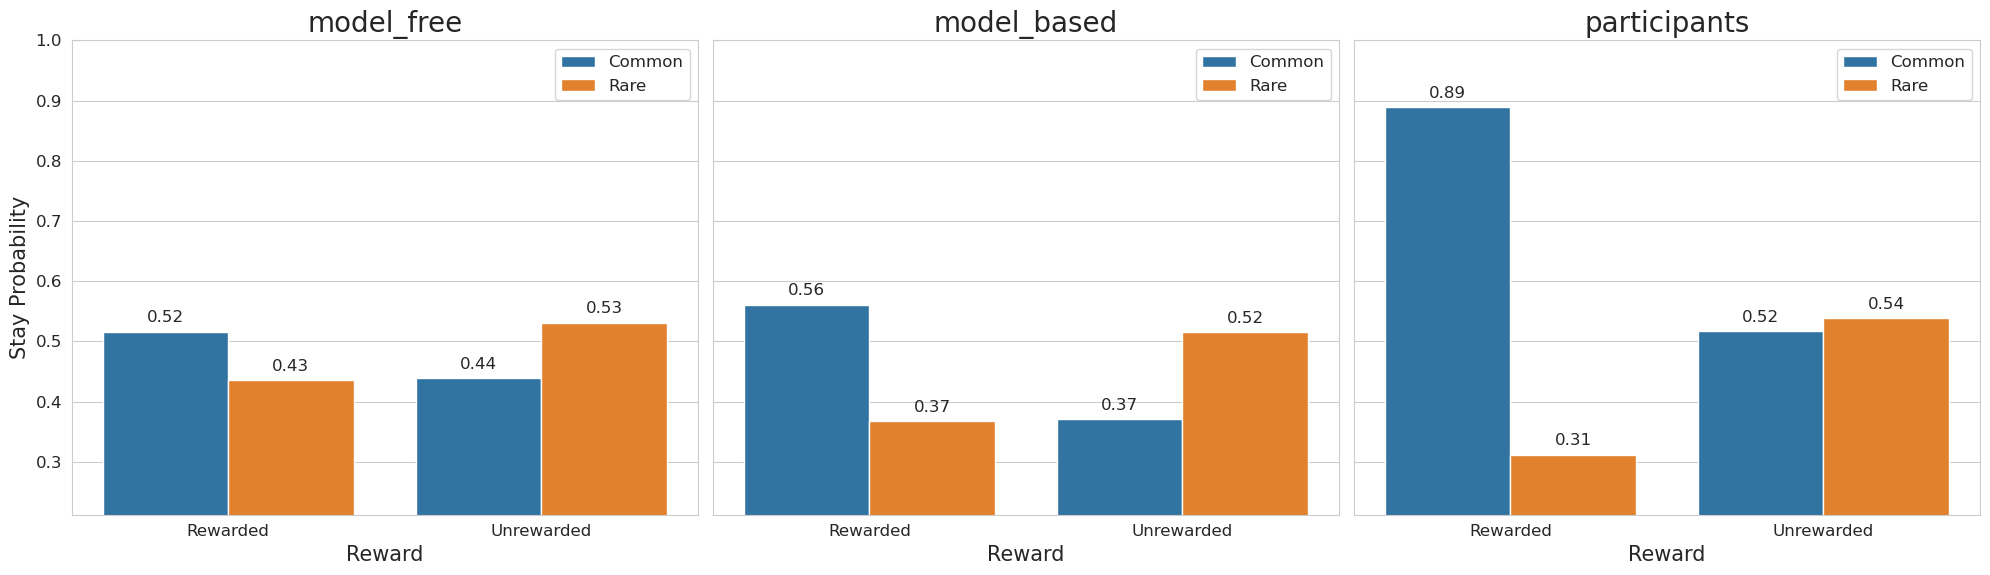

In [39]:
# print some statistics 
print_simple_statistics(task_df_mf, title='Model Free')
print_simple_statistics(task_df_mb, title='Model Based')
print_simple_statistics(human_data, title='Participant')

# calculate and plot stay probability
stay_probability_mf, _ = calculate_stay_probability(task_df_mf)
stay_probability_mb, _ = calculate_stay_probability(task_df_mb)
stay_probability_h, _ = calculate_stay_probability(human_data)

plot_stay_probabilities(dfs=[stay_probability_mf, stay_probability_mb, stay_probability_h],
                        labels=['model_free', 'model_based', 'participants'])

In [40]:
# plot progress across blocks
# stay probability across blocks
# reward across blocks
# best choice proportion across blocks


## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



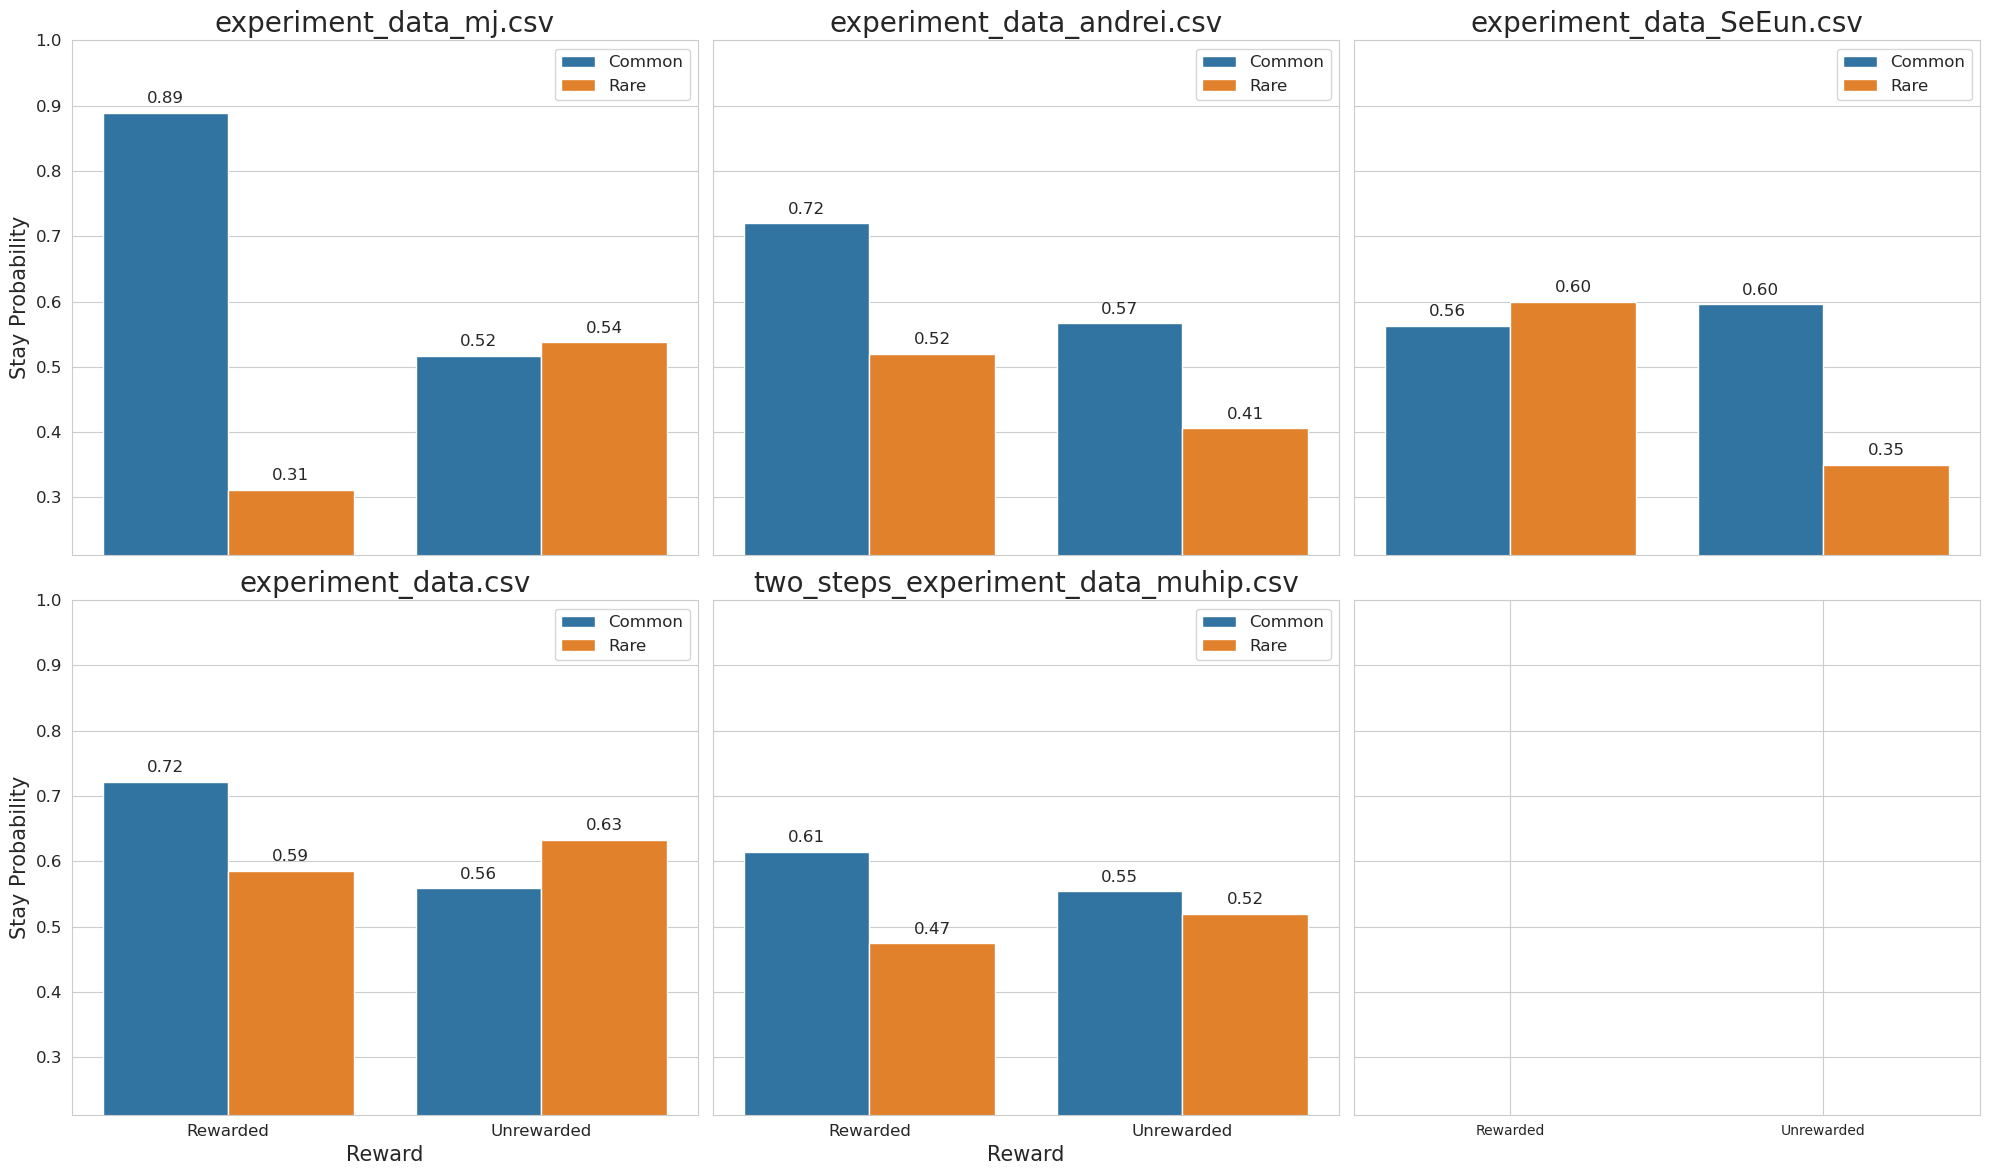

In [41]:
from simulate import simulate
from parameter_fitting import LL_for_params_search_space, log_likelihood, fit_to_average_accumulated_reward, plot_fit_results
from utils import preprocess_human_data, calculate_stay_probability, plot_stay_probability, plot_stay_probabilities, print_simple_statistics
from agents.random_agent import RandomAgent
from agents.model_free import AgentModelFree
from agents.model_based import AgentModelBased
from environment import TwoStepEnv
import numpy as np
import pandas as pd
import os

# load and inspect some human data
file_names = ['experiment_data_mj.csv', 'experiment_data_andrei.csv', 
              'experiment_data_SeEun.csv', 'experiment_data.csv', 'two_steps_experiment_data_muhip.csv']
stay_prob_list = []
human_data_list = [] 
for file_name in file_names:
    file_name = os.path.join("data", "participants", file_name)
    human_data = pd.read_csv(file_name)
    human_data = preprocess_human_data(human_data)
    human_data_list.append(human_data)
    
    stay_probability_h, _ = calculate_stay_probability(human_data)
    stay_prob_list.append(stay_probability_h)

plot_stay_probabilities(dfs=stay_prob_list, labels=file_names, max_plots_per_row=3)

In [42]:
# pick a participant to fit the model to
human_data = human_data_list[0]

# fit to average accumulated reward
interpolation_steps = 21
# alpha_space = np.linspace(0.05, 0.5 , interpolation_steps)
# beta_space = np.linspace(2, 6, interpolation_steps)
alpha_space = np.linspace(0, 1 , interpolation_steps)
beta_space = np.linspace(-10, 10, interpolation_steps)
parammeter_space = {'alpha': alpha_space,
                    'beta': beta_space}

# np.random.seed(2)   

# model_type = 'model_free'
consider_both_stages = True

# fit to using log likelihood of choices
fit_results_mb = LL_for_params_search_space(parammeter_space, human_data, agent_type='model_based',
                                            consider_both_stages=consider_both_stages)
fit_results_mf = LL_for_params_search_space(parammeter_space, human_data, agent_type='model_free',
                                            consider_both_stages=consider_both_stages)


agent_type: model_based, consider_both_stages: True
agent_type: model_free, consider_both_stages: True


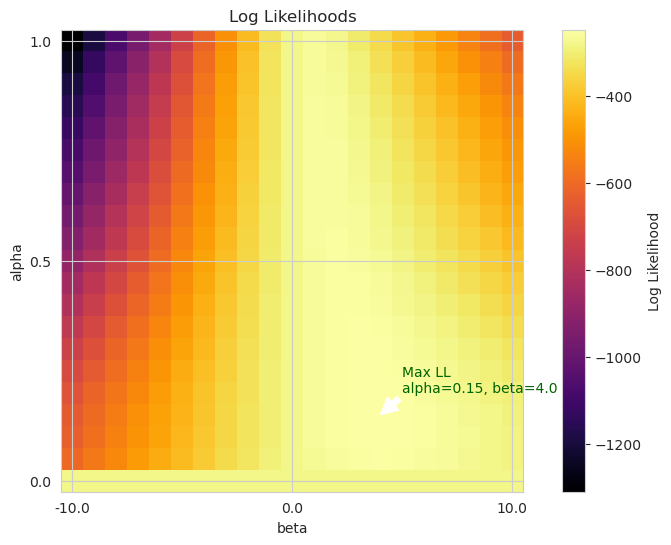

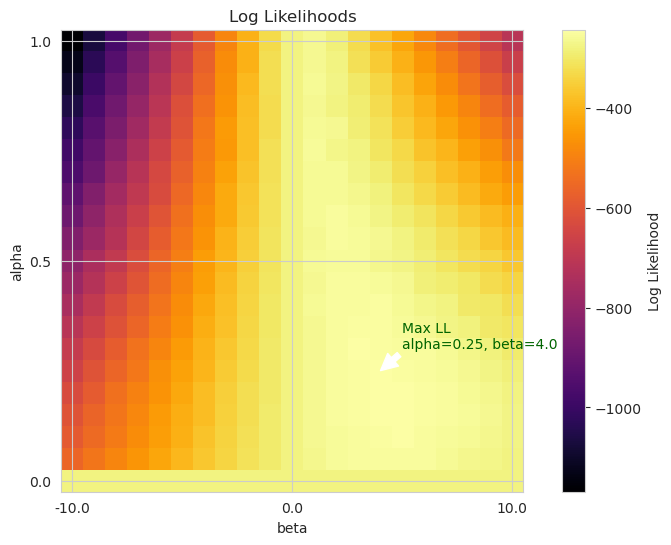

best_alpha_mb: 0.15000000000000002, best_beta_mb: 4.0
best_alpha_mf: 0.25, best_beta_mf: 4.0


In [43]:
# plot fit results
plot_fit_results(fit_results_mb, alpha_space, beta_space)
plot_fit_results(fit_results_mf, alpha_space, beta_space)

# get the best parameters model based
best_params_mb = np.unravel_index(fit_results_mb.argmax(), fit_results_mb.shape)
best_alpha_mb = alpha_space[best_params_mb[0]]
best_beta_mb = beta_space[best_params_mb[1]]
print(f'best_alpha_mb: {best_alpha_mb}, best_beta_mb: {best_beta_mb}')
best_params_mb = {'alpha': best_alpha_mb, 'beta': best_beta_mb}

# get the best parameters model free
best_params_mf = np.unravel_index(fit_results_mf.argmax(), fit_results_mf.shape)
best_alpha_mf = alpha_space[best_params_mf[0]]
best_beta_mf = beta_space[best_params_mf[1]]
print(f'best_alpha_mf: {best_alpha_mf}, best_beta_mf: {best_beta_mf}')
best_params_mf = {'alpha': best_alpha_mf, 'beta': best_beta_mf}

seed: 54
### model_based
common transitions percentage: 71.0 %
rewarded trails percentage: 58.5 %
### model_free
common transitions percentage: 71.0 %
rewarded trails percentage: 50.0 %
##################################################
seed: 2
### model_based
common transitions percentage: 63.0 %
rewarded trails percentage: 47.0 %
### model_free
common transitions percentage: 68.5 %
rewarded trails percentage: 41.5 %
##################################################
seed: 1
### model_based
common transitions percentage: 62.5 %
rewarded trails percentage: 50.5 %
### model_free
common transitions percentage: 70.0 %
rewarded trails percentage: 49.5 %
##################################################
seed: 34
### model_based
common transitions percentage: 70.5 %
rewarded trails percentage: 34.5 %
### model_free
common transitions percentage: 72.5 %
rewarded trails percentage: 50.5 %
##################################################
seed: 44
### model_based
common transitions percentage

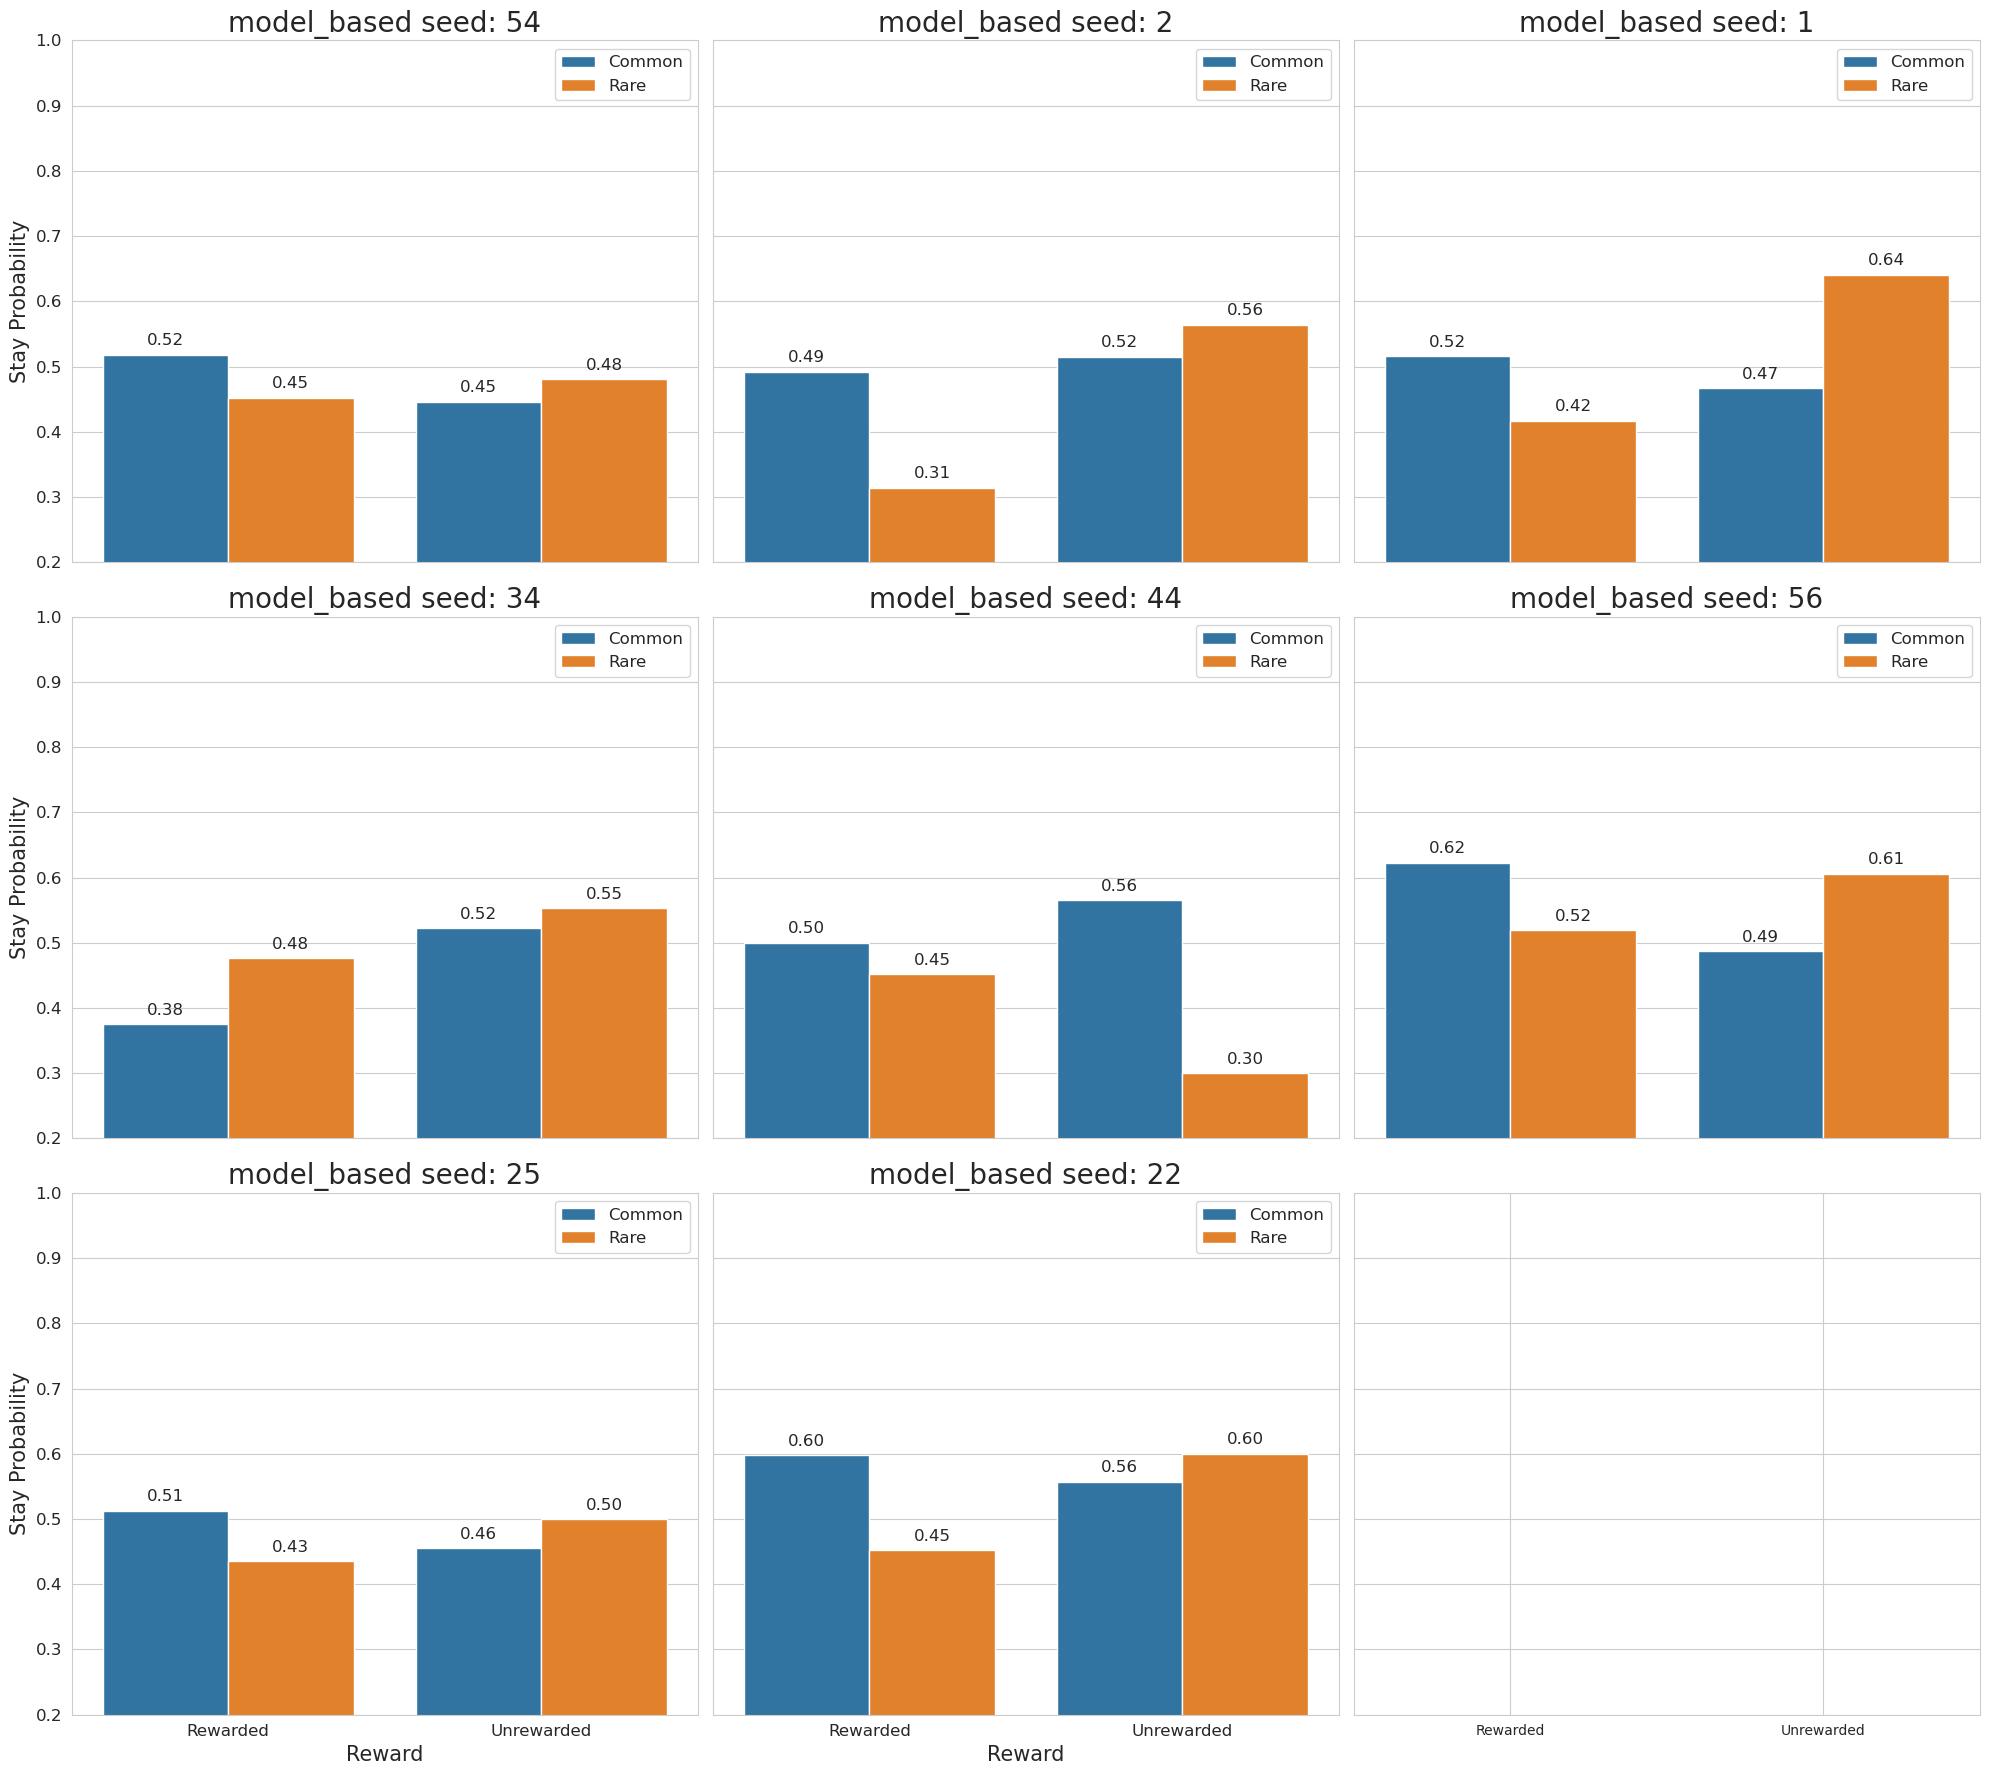

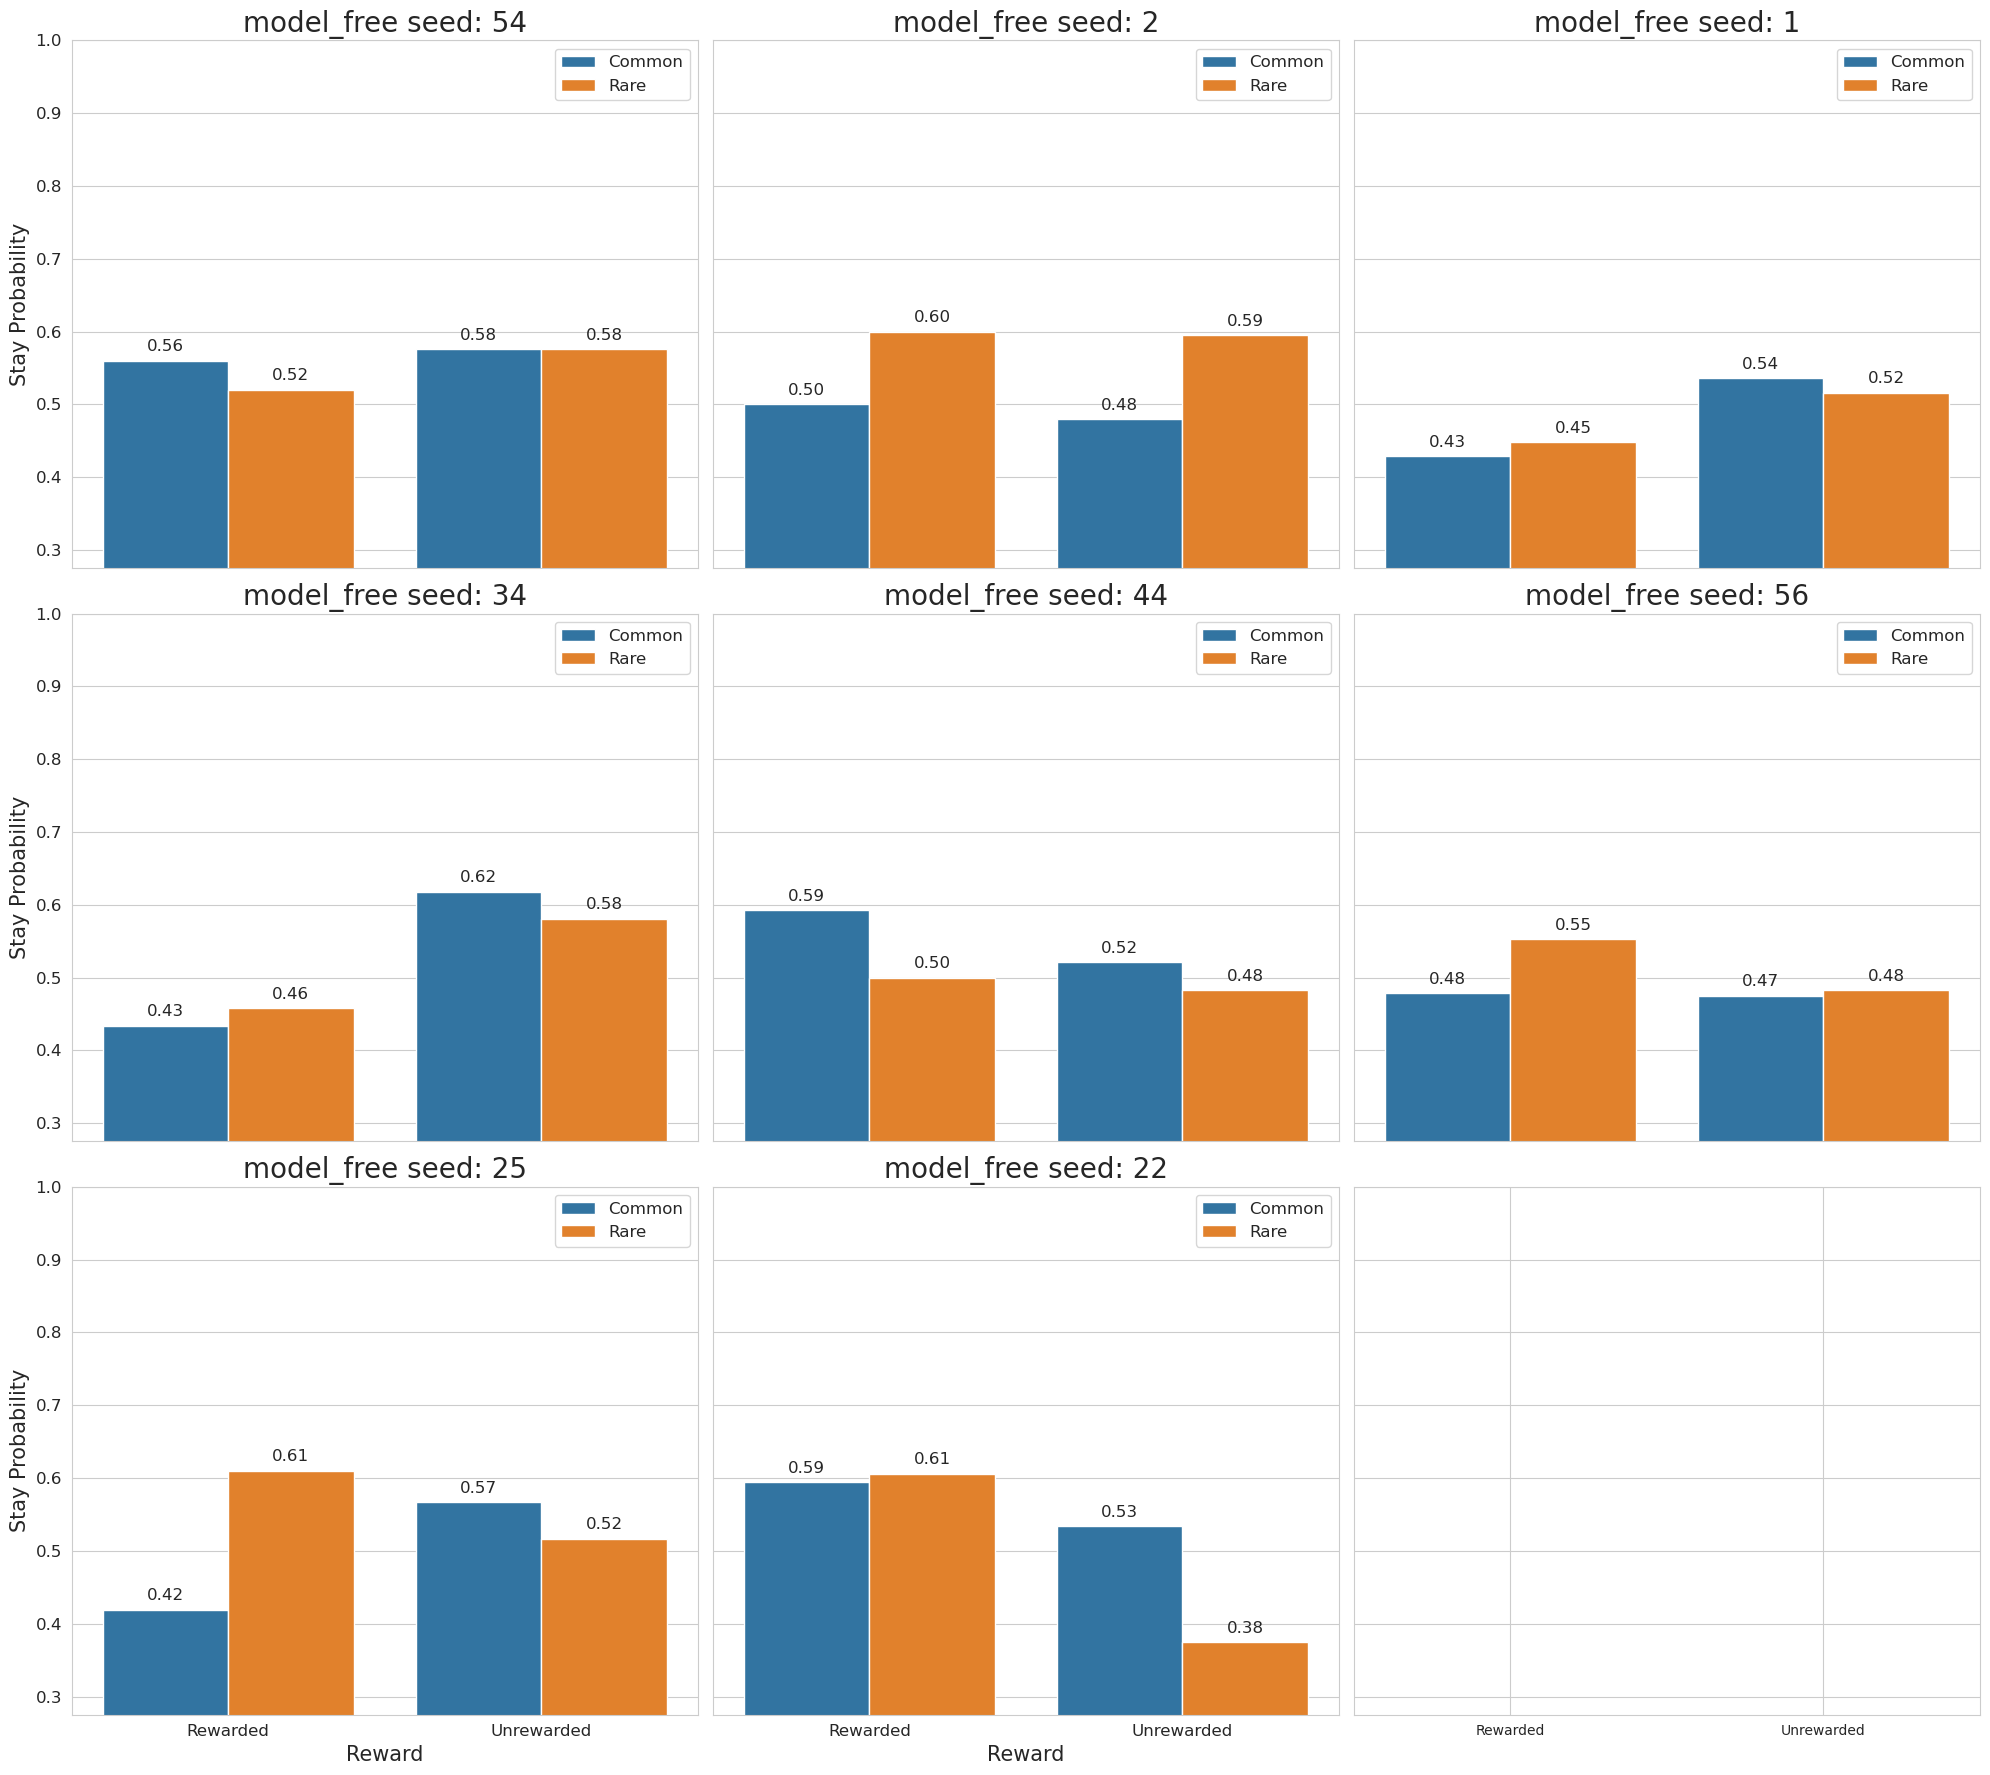

In [44]:
# simualte moltiple times and concatenate the data to average the results
# model_type = 'model_based'
# if model_type == 'model_based':
#     best_params = best_params_mb
# elif model_type == 'model_free':
#     best_params = best_params_mf
# else:
#     print('model type not recognized')

sample_size = 8
sampled_data_mb = []
sampled_data_mf = []
randome_seeds = np.random.randint(sample_size**2, size=sample_size)
for seed in randome_seeds:
    print(f'seed: {seed}')
    # data_best_mb, agent_best = simulate(model_type, seed=seed, params=best_params)
    data_best_mb, _ = simulate('model_based', seed=seed, params=best_params_mb)
    data_best_mf, _  = simulate('model_free', seed=seed, params=best_params_mf)

    # print some statistics 
    print_simple_statistics(data_best_mb, title='model_based')
    print_simple_statistics(data_best_mf, title='model_free')

    # calculate and plot stay probability
    stay_probability_df_mb, _ = calculate_stay_probability(data_best_mb)
    stay_probability_df_mf, _ = calculate_stay_probability(data_best_mf)
    # add to the data
    sampled_data_mb.append(stay_probability_df_mb)
    sampled_data_mf.append(stay_probability_df_mf)
    print('#'*50)

plot_stay_probabilities(dfs=sampled_data_mb, labels=[f'{"model_based"} seed: {s}' for s in randome_seeds], max_plots_per_row=3)
plot_stay_probabilities(dfs=sampled_data_mf, labels=[f'{"model_free"} seed: {s}' for s in randome_seeds], max_plots_per_row=3)

'model_based'

,Rewarded,Common,Condition,Stay Probability
0,False,False,unrewarded_rare,0.530625
1,False,True,unrewarded_common,0.501750
2,True,False,rewarded_rare,0.439625
3,True,True,rewarded_common,0.516875


'model_free'

,Rewarded,Common,Condition,Stay Probability
0,False,False,unrewarded_rare,0.515750
1,False,True,unrewarded_common,0.538375
2,True,False,rewarded_rare,0.536875
3,True,True,rewarded_common,0.501000


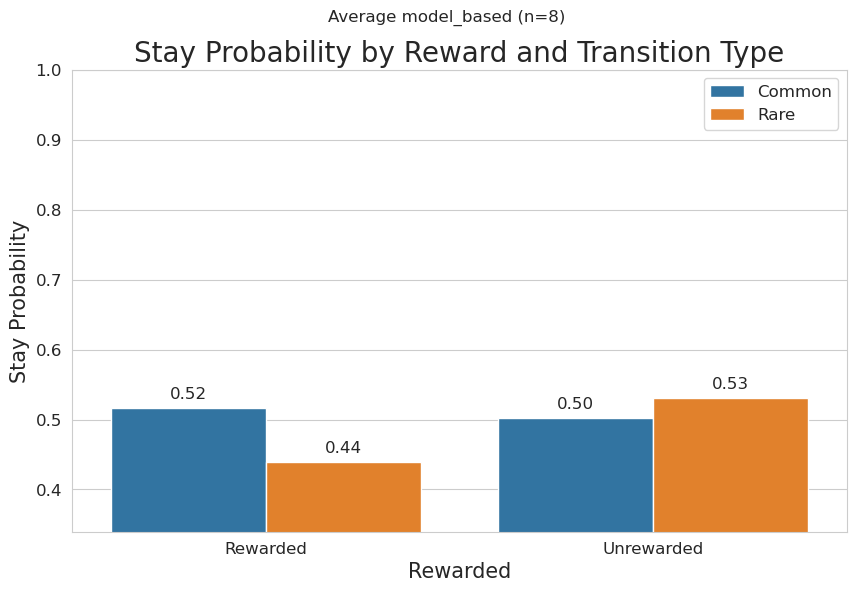

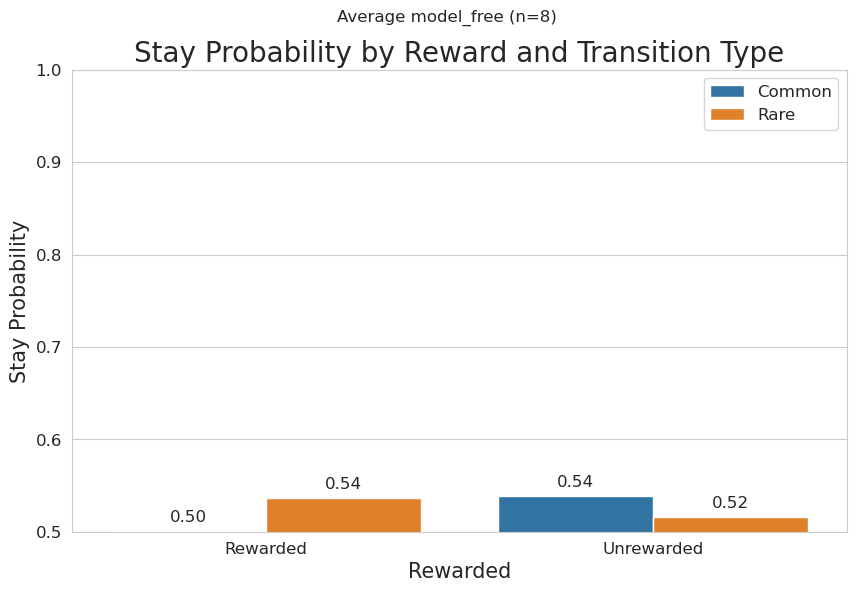

In [50]:
# take the average
all_data_mb = pd.concat(sampled_data_mb).reset_index(drop=True)
all_data_mf = pd.concat(sampled_data_mf).reset_index(drop=True)
# Compute the average stay probabilities
average_data_mb = all_data_mb.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_mf = all_data_mf.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
# display the average
display('model_based', average_data_mb)
display('model_free', average_data_mf)
# plot the average
plot_stay_probability(average_data_mb, title=f'Average {"model_based"} (n={sample_size})')
plot_stay_probability(average_data_mf, title=f'Average {"model_free"} (n={sample_size})')

{'diff_rewarded_rare': -0.07725, 'diff_unrewarded_rare': 0.028874999999999984, 'diff_rewarded_unrewarded': -0.10612499999999997}
{'diff_rewarded_rare': 0.03587500000000001, 'diff_unrewarded_rare': -0.022625000000000006, 'diff_rewarded_unrewarded': 0.05850000000000002}


/tmp/ipykernel_182635/4120756118.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45)
/tmp/ipykernel_182635/4120756118.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45)


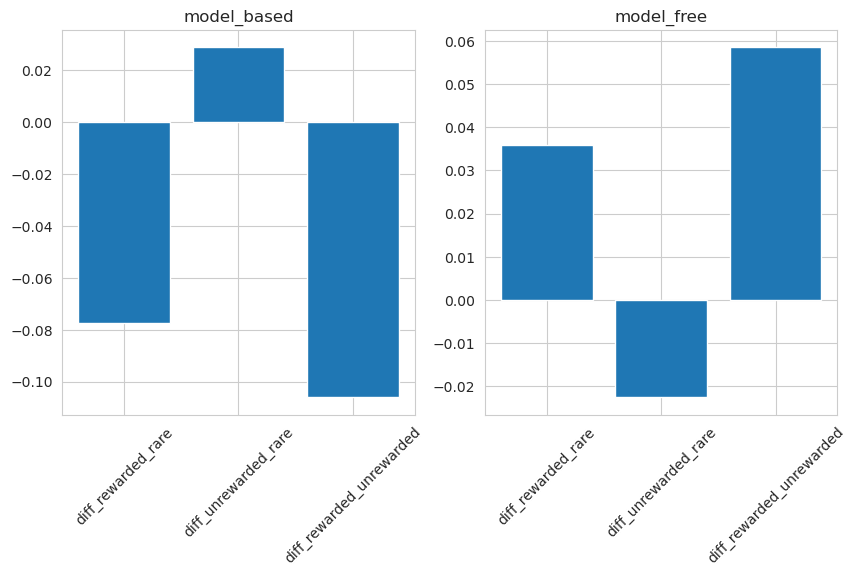

In [52]:
# first take the mean of the differences between rewarded common and rare transitions
# and unrewarded common and rare transitions
# then take the mean of the differences between the differences

# calculate the differences
diffs_mb = []
diffs_mf = []
for stay_prob_mb, stay_prob_mf in zip(sampled_data_mb, sampled_data_mf):
    diff_mb = {}
    rewarded_common = stay_prob_mb.loc[(stay_prob_mb['Rewarded']==True) & (stay_prob_mb['Common']==True), 'Stay Probability'].values[0]
    rewarded_rare = stay_prob_mb.loc[(stay_prob_mb['Rewarded']==True) & (stay_prob_mb['Common']==False), 'Stay Probability'].values[0]
    unrewarded_common = stay_prob_mb.loc[(stay_prob_mb['Rewarded']==False) & (stay_prob_mb['Common']==True), 'Stay Probability'].values[0]
    unrewarded_rare = stay_prob_mb.loc[(stay_prob_mb['Rewarded']==False) & (stay_prob_mb['Common']==False), 'Stay Probability'].values[0]
    diff_mb['rewarded_common'] = rewarded_common
    diff_mb['diff_rewarded_rare'] = rewarded_rare - rewarded_common
    diff_mb['unrewarded_common'] = unrewarded_common
    diff_mb['diff_unrewarded_rare'] = unrewarded_rare - unrewarded_common
    diff_mb['diff_rewarded_unrewarded'] = diff_mb['diff_rewarded_rare'] - diff_mb['diff_unrewarded_rare']
    diffs_mb.append(diff_mb)

    diff_mf = {}
    rewarded_common = stay_prob_mf.loc[(stay_prob_mf['Rewarded']==True) & (stay_prob_mf['Common']==True), 'Stay Probability'].values[0]
    rewarded_rare = stay_prob_mf.loc[(stay_prob_mf['Rewarded']==True) & (stay_prob_mf['Common']==False), 'Stay Probability'].values[0]
    unrewarded_common = stay_prob_mf.loc[(stay_prob_mf['Rewarded']==False) & (stay_prob_mf['Common']==True), 'Stay Probability'].values[0]
    unrewarded_rare = stay_prob_mf.loc[(stay_prob_mf['Rewarded']==False) & (stay_prob_mf['Common']==False), 'Stay Probability'].values[0]
    diff_mf['rewarded_common'] = rewarded_common
    diff_mf['diff_rewarded_rare'] = rewarded_rare - rewarded_common
    diff_mf['unrewarded_common'] = unrewarded_common
    diff_mf['diff_unrewarded_rare'] = unrewarded_rare - unrewarded_common
    diff_mf['diff_rewarded_unrewarded'] = diff_mf['diff_rewarded_rare'] - diff_mf['diff_unrewarded_rare']
    diffs_mf.append(diff_mf)
    

# take the mean of the differences
mean_diffs_mb = {}
# mean_diffs['rewarded_common'] = np.mean([diff['rewarded_common'] for diff in diffs])
# mean_diffs['diff_rewarded_rare'] = mean_diffs['rewarded_common'] + np.mean([diff['diff_rewarded_rare'] for diff in diffs])
mean_diffs_mb['diff_rewarded_rare'] = np.mean([diff['diff_rewarded_rare'] for diff in diffs_mb])

# mean_diffs['unrewarded_common'] = np.mean([diff['unrewarded_common'] for diff in diffs])
# mean_diffs['diff_unrewarded_rare'] = mean_diffs['unrewarded_common'] + np.mean([diff['diff_unrewarded_rare'] for diff in diffs])
mean_diffs_mb['diff_unrewarded_rare'] = np.mean([diff['diff_unrewarded_rare'] for diff in diffs_mb])
mean_diffs_mb['diff_rewarded_unrewarded'] = np.mean([diff['diff_rewarded_unrewarded'] for diff in diffs_mb])
print(mean_diffs_mb)

mean_diffs_mf = {}
# mean_diffs['rewarded_common'] = np.mean([diff['rewarded_common'] for diff in diffs])
# mean_diffs['diff_rewarded_rare'] = mean_diffs['rewarded_common'] + np.mean([diff['diff_rewarded_rare'] for diff in diffs])
mean_diffs_mf['diff_rewarded_rare'] = np.mean([diff['diff_rewarded_rare'] for diff in diffs_mf])

# mean_diffs['unrewarded_common'] = np.mean([diff['unrewarded_common'] for diff in diffs])
# mean_diffs['diff_unrewarded_rare'] = mean_diffs['unrewarded_common'] + np.mean([diff['diff_unrewarded_rare'] for diff in diffs])
mean_diffs_mf['diff_unrewarded_rare'] = np.mean([diff['diff_unrewarded_rare'] for diff in diffs_mf])
mean_diffs_mf['diff_rewarded_unrewarded'] = np.mean([diff['diff_rewarded_unrewarded'] for diff in diffs_mf])
print(mean_diffs_mf)



# plot the differences for both
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(mean_diffs_mb.keys(), mean_diffs_mb.values())
ax[0].set_title('model_based')
ax[1].bar(mean_diffs_mf.keys(), mean_diffs_mf.values())
ax[1].set_title('model_free')

# rotate the ticks
for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)
    
plt.show()


## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [47]:
from utils import calculate_running_step_probabilities, plot_running_step_probabilities


# Generate behavior from the model
task_df = calculate_running_step_probabilities(task_df)
plot_running_step_probabilities(task_df, window_size=20)

# Generate behavior from the human data
human_data = calculate_running_step_probabilities(human_data)
plot_running_step_probabilities(human_data, window_size=20)

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [48]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [49]:
# YOUR MODEL COMPARISON CODE GOES HERE